In [ ]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/data/exposure_Gaisser.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights
    # print(f"======> Total expected monopole events after weighting: {monopole_df['weight'].sum()} ======")
    return monopole_df

def give_bkg_mc_weights_gaisser(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Gaisser.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['gaisser_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['gaisser_weight']=pr_df['gaisser_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['gaisser_weight'].sum()} ======")
    return pr_df

def give_bkg_mc_weights_horandel(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Horandel.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['horandel_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['horandel_weight']=pr_df['horandel_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['horandel_weight'].sum()} ======")
    return pr_df

def give_exp_weights(exp_df, Ndays):
    exp_df['weight'] = np.ones(len(exp_df)) / Ndays / 86400
    # print(f"======> Total expected exposure events after weighting: {exp_df['weight'].sum()} ======")
    return exp_df

# paranmeters -> column name
dr_low=0  #  dr
theta_low=0 # rec_theta
theta_high=70 / 180.0 * np.pi

Rmean_low=25 # R_mean
Rmean_high=60

Eage_low=0.8   # Eage
Eage_high=1.6

log10TeV_low=1.8629710674285889 #  recE
log10TeV_high=2.2981839179992676

R_ue_high=-5.0 # optional R_ue


def filter_dataset(file, R_ue_cut=None):
    # Load the npz file
    # allow_pickle=True is often needed for object arrays or strings in npz
    data = np.load(file, allow_pickle=True)
    params = data['params']
    param_names = data['param_names']
    df_all = pd.DataFrame(params, columns=param_names)
    
    # Start filtering
    df = df_all.copy()
    print(f"Loading {file}...")
    print(f"Initial Total Events: {len(df)}")

    # Helper function to print the cut statistics
    def print_cut_stats(df_curr, len_prev, cut_name):
        len_curr = len(df_curr)
        ratio = (len_curr / len_prev * 100) if len_prev > 0 else 0
        print(f"Cut {cut_name}: {len_curr}/{len_prev}, left ratio= {ratio:.2f}%")

    # 1. Cut on dr (if column exists)
    if 'dr' in df.columns:
        prev_len = len(df)
        df = df[df['dr'] > dr_low]
        print_cut_stats(df, prev_len, f"dr > {dr_low}")

    # 2. Cut on rec_theta
    if 'rec_theta' in df.columns:
        prev_len = len(df)
        df = df[(df['rec_theta'] > theta_low) & (df['rec_theta'] < theta_high)]
        # For display, converting radians to degrees might be clearer, but keeping raw logic here
        print_cut_stats(df, prev_len, f"theta ({theta_low:.2f} ~ {theta_high:.2f} rad)")

    # 3. Cut on R_mean
    if 'R_mean' in df.columns:
        prev_len = len(df)
        df = df[(df['R_mean'] > Rmean_low) & (df['R_mean'] < Rmean_high)]
        print_cut_stats(df, prev_len, f"R_mean ({Rmean_low} ~ {Rmean_high})")

    # 4. Cut on Eage
    if 'Eage' in df.columns:
        prev_len = len(df)
        df = df[(df['Eage'] > Eage_low) & (df['Eage'] < Eage_high)]
        print_cut_stats(df, prev_len, f"Eage ({Eage_low} ~ {Eage_high})")

    # 5. Cut on recE (Energy)
    if 'recE' in df.columns:
        prev_len = len(df)
        # Calculate log10(E/TeV) safely
        # We perform the cut on the calculated series
        log10_E_TeV = df['recE']
        df = df[(log10_E_TeV > log10TeV_low) & (log10_E_TeV < log10TeV_high)]
        print_cut_stats(df, prev_len, f"recE log10TeV ({log10TeV_low:.3f} ~ {log10TeV_high:.3f})")

    # 6. Cut on R_ue (Optional/Specific)
    if 'R_ue' in df.columns and R_ue_cut is not None:
        prev_len = len(df)
        df = df[df['R_ue'] < R_ue_high] # Note: High cut usually means 'less than'
        print_cut_stats(df, prev_len, f"R_ue < {R_ue_high}")

    print(f"Final Event Count: {len(df)}")
    print("-" * 50)
    
    return df, df_all

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("Monopole Data Processing...")
mn_npz_file =  "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"
mn_df_large, mn_df_all_large = filter_dataset(mn_npz_file)
mn_df_large = give_sig_weights(mn_df_large); mn_df_all_large = give_sig_weights(mn_df_all_large)
# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nProton Data Processing...")
pr_npz_file = "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_fastcode.npz"
pr_df_large, pr_df_all_large = filter_dataset(pr_npz_file)
pr_df_large = give_bkg_mc_weights_gaisser(pr_df_large); pr_df_all_large = give_bkg_mc_weights_gaisser(pr_df_all_large)
# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nExperimental Rue Data Processing...")
exp_muon_Rue_npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/Rue1less_minus2/2024_Rue_minus1.9_noAge_cut_1e10_V04_dataset_fastcode.npz"
exp_muon_Rue_df_large, exp_muon_Rue_df_all_large = filter_dataset(exp_muon_Rue_npz_file)
exp_muon_Rue_df_large = give_exp_weights(exp_muon_Rue_df_large, Ndays=361); exp_muon_Rue_df_all_large = give_exp_weights(exp_muon_Rue_df_all_large, Ndays=361)



Monopole Data Processing...
Loading /home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz...
Initial Total Events: 103839
Cut dr > 0: 85248/103839, left ratio= 82.10%
Cut theta (0.00 ~ 1.22 rad): 85114/85248, left ratio= 99.84%
Cut R_mean (0 ~ 150): 84945/85114, left ratio= 99.80%
Cut Eage (0.8 ~ 1.6): 83373/84945, left ratio= 98.15%
Cut recE log10TeV (1.863 ~ 2.298): 80592/83373, left ratio= 96.66%
Final Event Count: 80592
--------------------------------------------------

Proton Data Processing...
Loading /home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_fastcode.npz...
Initial Total Events: 218095
Cut dr > 0: 190946/218095, left ratio= 87.55%
Cut theta (0.00 ~ 1.22 rad): 190944/190946, left ratio= 100.00%
Cut R_mean (0 ~ 150): 190932/190944, left ratio= 99.99%
Cut Eage (0.8 ~ 1.6): 190467/190932, left ratio= 99.76%
Cut recE log10TeV (1.863 ~ 2.298): 190438/190467, left ratio= 99.98%
Final

In [ ]:
# 定义筛选条件的字典组合
query= "1.9 < recE < 2.1 and R_ue < -2.6 and Eage < 1.08 and R_mean > 25 and R_mean < 60"
selection_configs = {
    "MN": {
        "df": mn_df_large,
        "query": query,
        "weight_col": "weight"
    },
    # "PR": {
    #     "df": pr_df_large,
    #     "query": "1.9 < recE < 2.1",
    #     "weight_col": "gaisser_weight"
    # },
    "EXP": {
        "df": exp_muon_Rue_df_all_large,
        "query":  query,
        "weight_col": "weight"
    }
}


def apply_selections(configs):
    results = {}
    SEC_PER_YEAR = 365 * 86400
    
    print(f"{'Dataset':<12} | {'Count':<8} | {'Ratio (%)':<10} | {'Annual Weight Sum':<18}")
    print("-" * 60)
    
    for name, cfg in configs.items():
        df = cfg['df']
        total_n = len(df)
        
        # --- 核心改进：添加 engine='python' 并处理索引 ---
        try:
            # 使用 engine='python' 解决负号解析导致的 UnaryOp 错误
            selected_df = df.query(cfg['query'], engine='python')
        except Exception as e:
            print(f"Error filtering {name}: {e}")
            continue
            
        selected_n = len(selected_df)
        selected_index = selected_df.index
        
        ratio = (selected_n / total_n * 100) if total_n > 0 else 0
        w_sum = selected_df[cfg['weight_col']].sum()
        annual_w_sum = w_sum * SEC_PER_YEAR
        
        results[name] = {
            "count": selected_n,
            "ratio": ratio,
            "annual_weight": annual_w_sum,
            "indices": selected_index
        }
        
        print(f"{name:<12} | {selected_n:<8} | {ratio:<10.4f} | {annual_w_sum:<18.2e}")
        
    return results
# 执行并获取结果
analysis_results = apply_selections(selection_configs)
exp_indices = analysis_results['EXP']['indices']
mn_indices = analysis_results['MN']['indices']


Dataset      | Count    | Ratio (%)  | Annual Weight Sum 
------------------------------------------------------------
MN           | 24520    | 30.4249    | 2.19e+02          
EXP          | 1709     | 0.0859     | 1.73e+03          


In [ ]:
# 479/np.sqrt(13000)  # 2.6
# 522/np.sqrt(18400)  # 2.55
373/np.sqrt(6880) # 2.8


4.496914316739093

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import itertools

def optimize_cuts_vectorized(df_signal, df_background, search_ranges, fixed_query=None):
    """
    极速优化的多参数切割搜索函数。
    支持任意数量的参数。使用直方图+累积求和技术，比循环快 100-1000 倍。
    
    参数:
    res_df -- (输出) 包含所有网格点计算结果的 DataFrame
    """
    # --- 1. 数据预处理 ---
    print("Preparing data (Vectorized)...")
    
    # 预筛选
    if fixed_query:
        s_df = df_signal.query(fixed_query)
        b_df = df_background.query(fixed_query)
    else:
        s_df = df_signal
        b_df = df_background

    scale = 365 * 86400
    # 获取权重 (处理可能的列名差异)
    ws = (s_df['gaisser_weight'].values if 'gaisser_weight' in s_df else s_df['weight'].values) * scale
    wb = b_df['weight'].values * scale

    # 提取参数名和配置
    param_names = list(search_ranges.keys())
    n_params = len(param_names)
    
    # --- 2. 构建 N维 直方图网格 ---
    # 我们需要构建 bin_edges，为了确保统计正确（包含小于start或大于stop的数据），
    # 我们在两端扩展无穷大区间。
    
    bins_list = []
    grids_map = {} # 用于存储真实的切点值，方便后续还原
    operators = []
    
    # 准备直方图数据容器
    sample_s = np.zeros((len(ws), n_params))
    sample_b = np.zeros((len(wb), n_params))
    
    for i, p in enumerate(param_names):
        start, stop, step, op = search_ranges[p]
        operators.append(op)
        
        # 提取数据列
        sample_s[:, i] = s_df[p].values
        sample_b[:, i] = b_df[p].values
        
        # 生成切点网格 (用户定义的搜索点)
        # 注意：np.arange 通常不包含 stop，加一个小量确保包含
        grid = np.arange(start, stop + step/1000.0, step)
        grids_map[p] = grid
        
        # 构建直方图边缘 (Edges)
        # 原理：如果切点是 v，op是 '<'，意味着我们要统计 (-inf, v) 
        # 为了利用 cumsum，我们将 grid 作为 bin 的右边缘 (对于 <) 或 左边缘 (对于 >)
        # 这里为了通用，我们构建极其精细的 bins，或者简单地将 grid 点作为 bin edges
        
        # 技巧：我们将 grid 点作为 bin 的边缘。
        # 并在首尾加上 -inf 和 inf 来捕获所有溢出数据
        edges = np.concatenate([[-np.inf], grid, [np.inf]])
        bins_list.append(edges)

    print(f"Binning data into {n_params}D histogram (Grid size: {[len(g) for g in grids_map.values()]} )...")
    
    # --- 3. 核心加速：加权直方图 ---
    # 计算信号和本底在网格中的分布
    # histogramdd 返回的 H 是多维数组，形状为 (len(grid)+1, len(grid)+1, ...)
    H_s, _ = np.histogramdd(sample_s, bins=bins_list, weights=ws)
    H_b, _ = np.histogramdd(sample_b, bins=bins_list, weights=wb)
    
    # --- 4. 核心加速：多维累积求和 (CumSum) ---
    # 根据操作符方向计算“保留下来的”事件总权重
    
    # 这一步将 概率密度(PDF) 转换为 累积分布(CDF) 也就是 Cut后的保留量
    current_S = H_s
    current_B = H_b
    
    for axis_idx, op in enumerate(operators):
        if op == '<':
            # 如果是 < cut，我们保留小的值。
            # 在直方图中，这意味着从左向右累加 (cumsum)
            # bin[0] 是 -inf 到 grid[0]，保留它意味着 cut 在 grid[0]
            # 累加后，index i 的值代表 sum(bin[0]...bin[i])，即 cut < edges[i+1]
            current_S = np.cumsum(current_S, axis=axis_idx)
            current_B = np.cumsum(current_B, axis=axis_idx)
            
        elif op == '>':
            # 如果是 > cut，我们保留大的值。
            # 这意味着从右向左累加。
            # numpy 没有直接的 reverse cumsum，我们先 flip 轴，cumsum，再 flip 回来
            current_S = np.flip(np.cumsum(np.flip(current_S, axis=axis_idx), axis=axis_idx), axis=axis_idx)
            current_B = np.flip(np.cumsum(np.flip(current_B, axis=axis_idx), axis=axis_idx), axis=axis_idx)

    # --- 5. 提取有效网格区域 ---
    # 我们的 edges 是 [-inf, g0, g1, ... gn, inf]
    # 直方图 H 的形状是 (n_grid + 1)
    # 对于 '<':
    #   H[0] 是 (-inf, g0)。cumsum 后 H[0] 代表 < g0 的总和。
    #   H[1] 是 (g0, g1)。cumsum 后 H[1] 代表 < g1 的总和。
    #   我们需要的切点对应的值正好是 index 0 到 n-1
    # 对于 '>':
    #   H[last] 是 (gn, inf)。 cumsum(from right) 后 H[last] 代表 > gn 的总和。
    #   我们需要对齐 grid。
    
    # 为了对齐 grid 和 数组索引，我们需要切片 (Slicing)
    slices = []
    for axis_idx, op in enumerate(operators):
        n_grid = len(grids_map[param_names[axis_idx]])
        if op == '<':
            # index 0 对应 cut < grid[0]
            # index n-1 对应 cut < grid[n-1]
            # 最后一个 bin 是 (grid[last], inf)，无论是 < 还是 > 逻辑，通常 cut 扫描不包含无穷大
            slices.append(slice(0, n_grid)) 
        else:
            # op == '>'
            # edges: [-inf, g0, g1, ... gn, inf]
            # bins:  b0,   b1, ...      bn,  bn+1
            # b0=(-inf, g0), bn=(gn-1, gn), bn+1=(gn, inf)
            # Reverse Cumsum 后:
            # H[n+1] = sum(bn+1) -> > gn
            # H[n]   = sum(bn+1, bn) -> > gn-1
            # H[1]   = sum(..., b1) -> > g0
            # 所以 grid[0] (g0) 对应 H[1]
            slices.append(slice(1, n_grid + 1))

    # 应用切片，使矩阵维度与 grid 维度完全一致
    final_S = current_S[tuple(slices)]
    final_B = current_B[tuple(slices)]
    
    # --- 6. 计算显著性 ---
    with np.errstate(divide='ignore', invalid='ignore'):
        sig_matrix = final_S / np.sqrt(final_B)
        sig_matrix[final_B <= 0] = 0 # 处理除零
        sig_matrix[np.isnan(sig_matrix)] = 0

    # --- 7. 寻找最佳点并格式化输出 ---
    # 找到最大值的索引（扁平化索引）
    best_idx_flat = np.argmax(sig_matrix)
    # 转换回多维索引
    best_idx_tuple = np.unravel_index(best_idx_flat, sig_matrix.shape)
    
    best_sig = sig_matrix[best_idx_tuple]
    best_S = final_S[best_idx_tuple]
    best_B = final_B[best_idx_tuple]
    
    best_cuts = {}
    for i, p in enumerate(param_names):
        idx = best_idx_tuple[i]
        val = grids_map[p][idx]
        best_cuts[p] = val

    print("-" * 50)
    print(f"Optimization Done ({n_params} params).")
    print(f"Max Significance: {best_sig:.4f}")
    print(f"Signal: {best_S:.2e} | Background: {best_B:.2e}")
    print(f"Best Cuts: {best_cuts}")
    
    # --- 8. 生成结果 DataFrame (为了画图) ---
    # 如果网格非常大，生成全量 DataFrame 会很慢。
    # 这里我们生成坐标网格，然后展平
    print("Generating result DataFrame...")
    
    # 使用 meshgrid 生成所有坐标组合
    # indexing='ij' 确保维度顺序与 matrix 一致
    coords = np.meshgrid(*[grids_map[p] for p in param_names], indexing='ij')
    
    # 展平所有数据
    flat_data = {}
    for i, p in enumerate(param_names):
        flat_data[p] = coords[i].ravel()
    
    flat_data['S'] = final_S.ravel()
    flat_data['B'] = final_B.ravel()
    flat_data['significance'] = sig_matrix.ravel()
    
    res_df = pd.DataFrame(flat_data)
    
    # 过滤掉无意义的数据减小体积 (可选)
    # res_df = res_df[res_df['significance'] > 0] 

    return best_cuts, res_df

def plot_optimization_heatmap(res_df, param_x, param_y, fixed_param=None, fixed_val_approx=None):
    """
    通用画图函数：支持任意两个参数的热力图，可选择是否固定第三个参数
    """
    df_plot = res_df.copy()
    
    title_extra = ""
    
    # 如果指定了固定参数，进行筛选
    if fixed_param and fixed_val_approx is not None:
        # 自动推断步长做 tolerance，如果没有步长信息，默认 0.001
        # 这里简单处理，取 unique 值的最小差值的一半
        unique_vals = np.sort(df_plot[fixed_param].unique())
        if len(unique_vals) > 1:
            step = np.min(np.diff(unique_vals))
            tolerance = step / 2.0
        else:
            tolerance = 1e-5
            
        mask = np.abs(df_plot[fixed_param] - fixed_val_approx) < tolerance
        df_plot = df_plot[mask]
        title_extra = f"\nFixed {fixed_param} $\\approx$ {fixed_val_approx:.2f}"
        
        if len(df_plot) == 0:
            print(f"Warning: No data found for {fixed_param} approx {fixed_val_approx}")
            return

    # 聚合：如果除了 param_x, param_y 还有其他变动的参数（未被固定），
    # 我们通常取这些未固定参数下的 最大显著性 (Best profile)
    # 也就是：在 X, Y 确定的情况下，其他参数调到最优时的结果
    pivot_table = df_plot.pivot_table(index=param_y, columns=param_x, values='significance', aggfunc='max')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=False, cmap="viridis", cbar_kws={'label': r'Significance ($S/\sqrt{B}$)'})
    
    # 标出最大值位置
    # 找到最大值的坐标
    max_val = pivot_table.max().max()
    # 注意：这里仅仅是可视化标点，实际数值应参考 optimize_cuts 的返回值
    
    plt.title(f"Optimization Scan: {param_x} vs {param_y}{title_extra}")
    plt.xlabel(f"Cut on {param_x}")
    plt.ylabel(f"Cut on {param_y}")
    plt.gca().invert_yaxis()
    plt.show()

# --- 使用示例 ---

# 1. 定义任意参数 (只需修改字典)
# 注意：即使只有一个参数，或者有5个参数，代码都不需要改动
ranges_new = {
    "R_ue":   (-3.5, -2.0, 0.02, '<'), 
    "Eage":   (1,  1.2,  0.02, '<'), 
    # "R_mean": (10,   60,   2.0,  '>'),
    # 你甚至可以加第四个参数：
    # "Zenith": (0,    60,   5.0,  '<') 
}

# 2. 运行优化
# mn_df_large 和 exp_muon_Rue_df_all_large 需替换为你实际的 DataFrame 变量名
best_cuts, res_df = optimize_cuts_vectorized(
    mn_df_large, 
    exp_muon_Rue_df_all_large, 
    ranges_new, 
    fixed_query="1.9 < recE < 2.1  and R_mean > 25 and R_mean < 60"
)

# 3. 画图
# 场景 A: 3个参数，固定 R_mean 画 R_ue vs Eage
# plot_optimization_heatmap(res_df, "R_ue", "Eage", "R_mean", best_cuts['R_mean'])

# 场景 B: 哪怕你有4个参数，也可以只指定 X 和 Y，函数会自动取其他参数的最优投影 (Profile Likelihood)
# plot_optimization_heatmap(res_df, "R_ue", "Eage")


Preparing data (Vectorized)...
Binning data into 2D histogram (Grid size: [76, 11] )...
--------------------------------------------------
Optimization Done (2 params).
Max Significance: 5.2570
Signal: 2.19e+02 | Background: 1.73e+03
Best Cuts: {'R_ue': -2.7999999999999994, 'Eage': 1.08}
Generating result DataFrame...


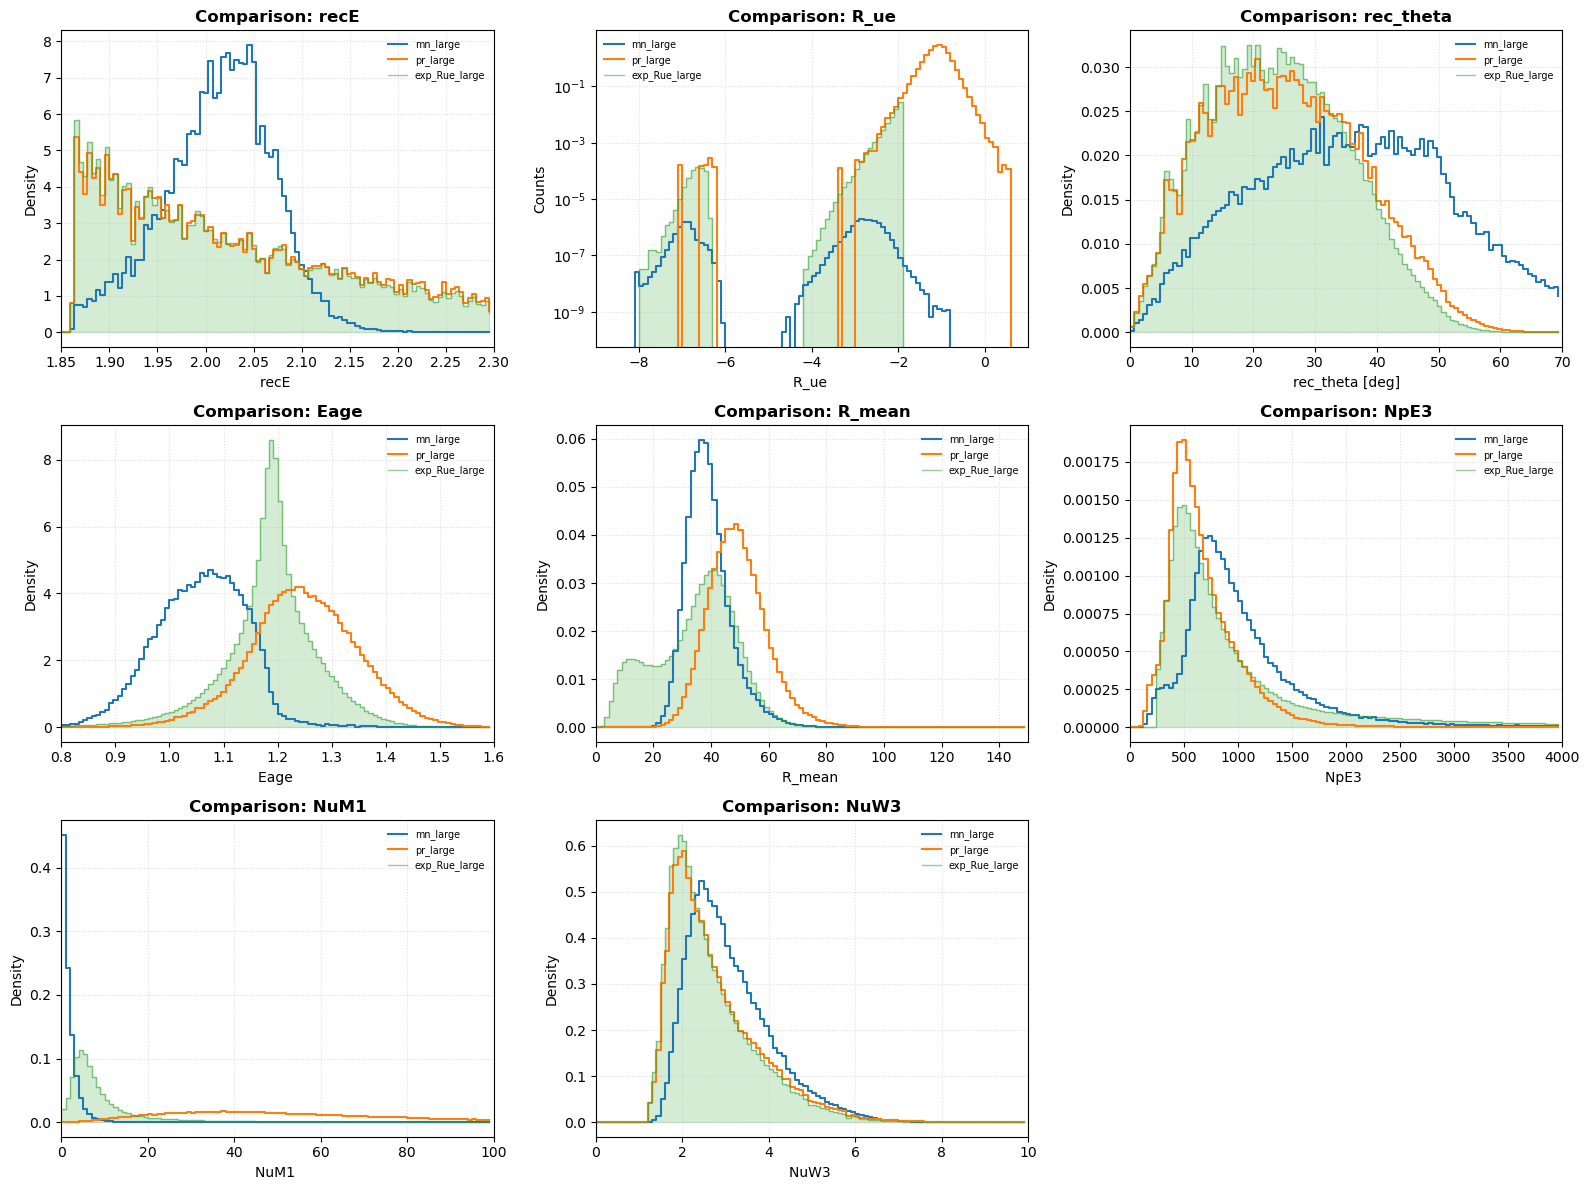

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_hist_grid(df_list: dict, param_configs: dict, bins=100, alpha=0.8, figsize=(16, 12)):
    params = list(param_configs.keys())
    n_params = len(params)
    
    n_cols = min(3, n_params)
    n_rows = int(np.ceil(n_params / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()
    
    # 颜色循环
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for idx, p_name in enumerate(params):
        ax = axes[idx]
        cfg = param_configs[p_name]
        
        p_range = cfg.get('range', None)
        use_log = cfg.get('log', False)
        use_density = cfg.get('density', True)

        # 1. 自动计算范围（如果未指定）
        if p_range is None:
            valid_dfs = [df[p_name].values for df in df_list.values() if p_name in df.columns]
            if valid_dfs:
                p_range = (np.nanmin([np.nanmin(v) for v in valid_dfs]), 
                           np.nanmax([np.nanmax(v) for v in valid_dfs]))

        # 2. 遍历数据源，使用 NumPy 预计算
        for d_idx, (df_name, df) in enumerate(df_list.items()):
            if p_name not in df.columns:
                continue
            
            # 提取数据并转为 float 数组
            vals = df[p_name].values.astype(float)
            
            # 权重处理
            w_col = next((c for c in ['gaisser_weight', 'weight'] if c in df.columns), None)
            weights = df[w_col].values.astype(float) if w_col else None
            
            # 处理角度转换逻辑
            curr_range = list(p_range) if p_range else None
            if p_name == 'rec_theta' and np.nanmax(vals) < 4.0: # 粗略判断弧度
                vals = np.degrees(vals)
                

            # 过滤 NaN 提高速度
            mask = ~np.isnan(vals)
            if weights is not None:
                mask &= ~np.isnan(weights)
            
            # 3. 使用 NumPy 计算直方图数据
            counts, bin_edges = np.histogram(
                vals[mask], bins=bins, range=curr_range, 
                weights=weights[mask] if weights is not None else None,
                density=use_density
            )
            
            # 4. 绘图：使用 ax.step 模拟 histtype='step'
            # 为了美观，我们在边缘补零
            x = np.repeat(bin_edges, 2)
            y = np.concatenate(([0], np.repeat(counts, 2), [0]))
            
            # 实验组(含有'exp'字样)用填充，模拟你之前的需求
            if 'exp' in df_name.lower():
                ax.fill_between(bin_edges[:-1], counts, step='post', 
                                alpha=0.2, color=colors[d_idx % len(colors)])
                ax.step(bin_edges[:-1], counts, where='post', 
                        label=df_name, color=colors[d_idx % len(colors)], linewidth=1, alpha=0.5)
            else:
                ax.step(bin_edges[:-1], counts, where='post', 
                        label=df_name, color=colors[d_idx % len(colors)], linewidth=1.5)

        # 5. 修饰
        ax.set_title(f"Comparison: {p_name}", fontweight='bold')
        ax.set_xlabel(f"{p_name} {'[deg]' if p_name == 'rec_theta' else ''}")
        ax.set_ylabel('Density' if use_density else 'Counts')
        
        if use_log:
            ax.set_yscale('log')
        
        if curr_range:
            ax.set_xlim(curr_range)
            
        ax.legend(fontsize='x-small', frameon=False)
        ax.grid(True, linestyle=':', alpha=0.4)

    # 隐藏多余子图
    for j in range(n_params, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()

# 将参数配置整合进一个字典，结构更清晰
configs = {
    "recE":      {"range": (1.85, 2.3), "log": False, "density": True},
    "R_ue":      {"range": (-9, 1), "log": True,  "density": False},
    "rec_theta": {"range": (0, 70),   "log": False, "density": True},
    "Eage":      {"range": (0.8, 1.6),"log": False, "density": True},
    "R_mean":    {"range": (0, 150), "log": False, "density": True},
    "NpE3":      {"range": (0, 4000), "log": False, "density": True},
    "NuM1":      {"range": (0, 100), "log": False, "density": True},
    "NuW3":      {"range": (0, 10), "log": False, "density": True},
    
}

# 使用示例
df_list = {
    "mn_large": mn_df_large,
    "pr_large": pr_df_large,
    "exp_Rue_large": exp_muon_Rue_df_large
}
plot_hist_grid(
    df_list=df_list, 
    param_configs=configs,

    alpha=0.9
)


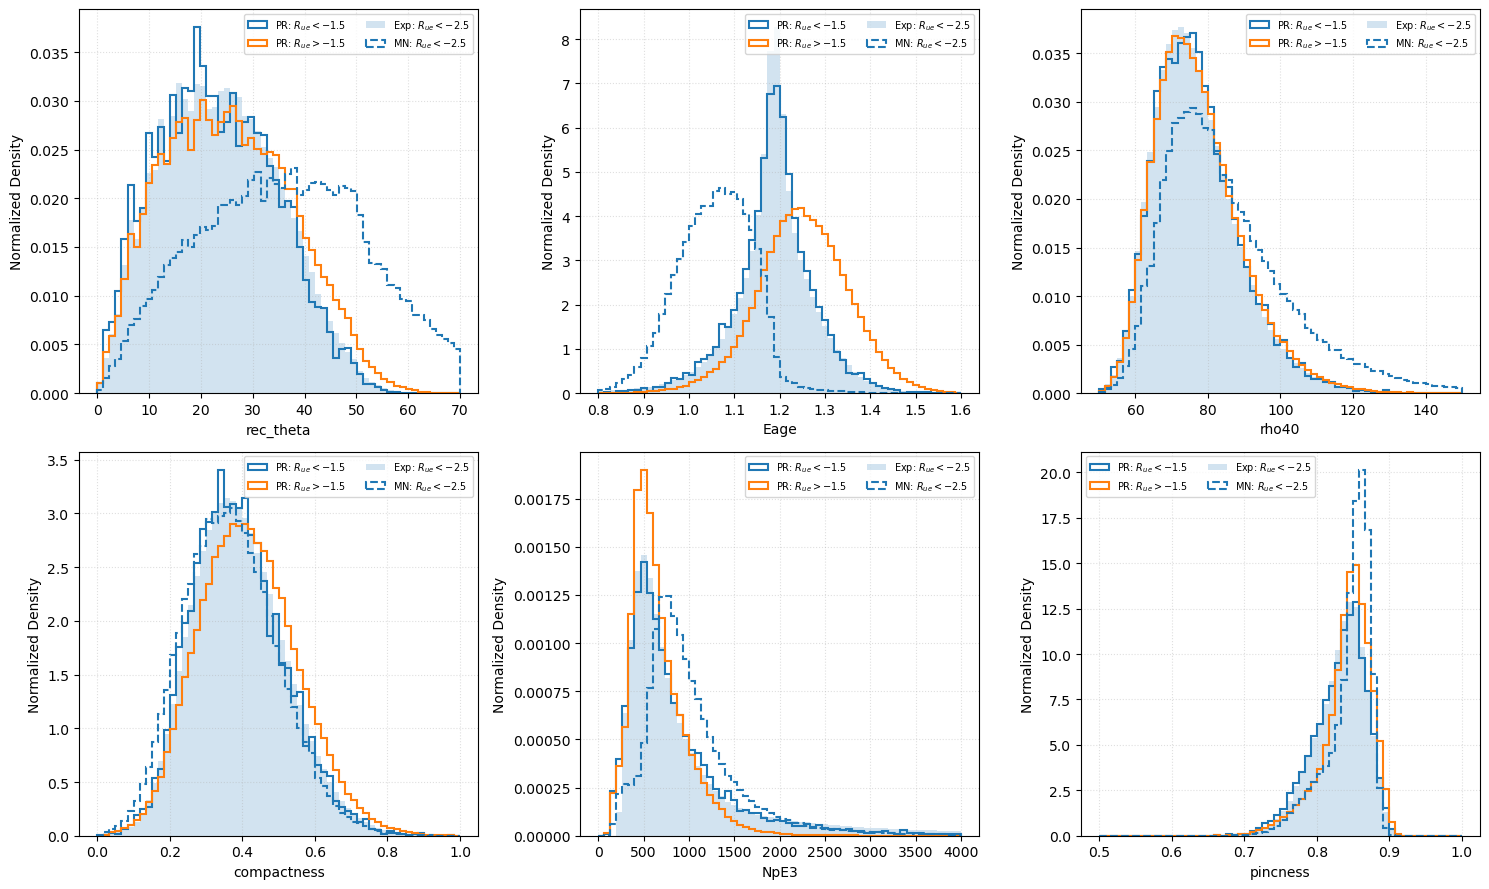

In [22]:

import numpy as np
import matplotlib.pyplot as plt


def generate_bin_labels(bins):
    """根据 bins 列表自动生成数学表达式标签"""
    labels = []
    for i in range(len(bins) - 1):
        low, high = bins[i], bins[i+1]
        if low == -np.inf:
            labels.append(f'$R_{{ue}} < {high}$')
        elif high == np.inf:
            labels.append(f'$R_{{ue}} > {low}$')
        else:
            labels.append(f'${low} < R_{{ue}} < {high}$')
    return labels

def plot_rue_slices(df_pr, df_exp, df_mn=None):
    param_configs = {
        # 'recE':      {'range': (1.85, 2.15), 'label': 'log10(recE/TeV)'},
        # 'R_mean':    {'range': (0, 90),      'label': 'R_mean'},
        'rec_theta': {'range': (0, 70),      'label': 'rec_theta'},
        'Eage':      {'range': (0.8, 1.6),   'label': 'Eage'},
        'rho40':     {'range':(50,150),      'label': 'rho40'},
        'compactness':  {'range':(0.,1),       'label': 'compactness'},
        # 'NuM1':     {'range':(0,50),      'label': 'NuM1'},
        'NpE3':     {'range':(0,4000),      'label': 'NpE3'},
        'pincness':  {'range':(0.5,1),       'label': 'pincness'},

    }

    # 1. 核心配置：只需定义 bins
    raw_configs = {
        'PR':  {'df': df_pr,  'bins': [-np.inf, -1.5,np.inf], 'w': 'gaisser_weight', 
                'style': {'histtype': 'step', 'linewidth': 1.5}},
        'Exp': {'df': df_exp, 'bins': [-np.inf, -2.5], 'w': 'weight', 
                'style': {'histtype': 'stepfilled', 'alpha': 0.2}},
        'MN':  {'df': df_mn,  'bins': [-np.inf, -2.5], 'w': 'weight', 
                'style': {'histtype': 'step', 'linewidth': 1.5, 'linestyle': '--'}}
    }

    # 2. 预处理数据源：过滤 None 并生成 labels
    data_sources = {}
    for key, cfg in raw_configs.items():
        if cfg['df'] is not None:
            data_sources[key] = cfg
            data_sources[key]['labels'] = generate_bin_labels(cfg['bins'])

    fig, axes = plt.subplots(2, 3, figsize=(15, 9))
    axes = axes.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # 3. 绘图循环
    for i, (p_name, p_cfg) in enumerate(param_configs.items()):
        ax = axes[i]
        
        for src_name, s in data_sources.items():
            # NumPy 向量化操作
            rue_vals = s['df']['R_ue'].values
            weights = s['df'][s['w']].values
            idx = np.digitize(rue_vals, s['bins'][1:-1])
            
            raw_vals = s['df'][p_name].values
            vals = raw_vals * (180 / np.pi) if p_name == 'rec_theta' else raw_vals
            
            for j, bin_label in enumerate(s['labels']):
                mask = (idx == j)
                if not np.any(mask): continue
                
                ax.hist(vals[mask], bins=60, density=True, 
                        range=p_cfg['range'],
                        weights=weights[mask], 
                        color=colors[j % len(colors)],
                        label=f"{src_name}: {bin_label}", 
                        **s['style'])

        # ax.set_title(f"Comparison: {p_cfg['label']}", fontweight='bold')
        ax.set_xlabel(p_cfg['label'])
        ax.set_ylabel("Normalized Density")
        ax.legend(fontsize='7', ncol=2, loc='best')
        ax.grid(True, linestyle=':', alpha=0.4)

    plt.tight_layout()
    plt.show()
# 执行绘图
plot_rue_slices(pr_df_large, exp_muon_Rue_df_large, mn_df_large)

#  先进行cut, 然后利用选用参数Eage ,rec_theta , rho40进行分类
query= "1.9 < recE < 2.1 and R_ue < -2.6 and Eage < 1.18 and R_mean > 25 and R_mean < 60"


>>> 开始验证形状不变性...
    MC Cuts: [-1.5, -1.8, -2.0]
    Exp Target: R_ue < -2.5


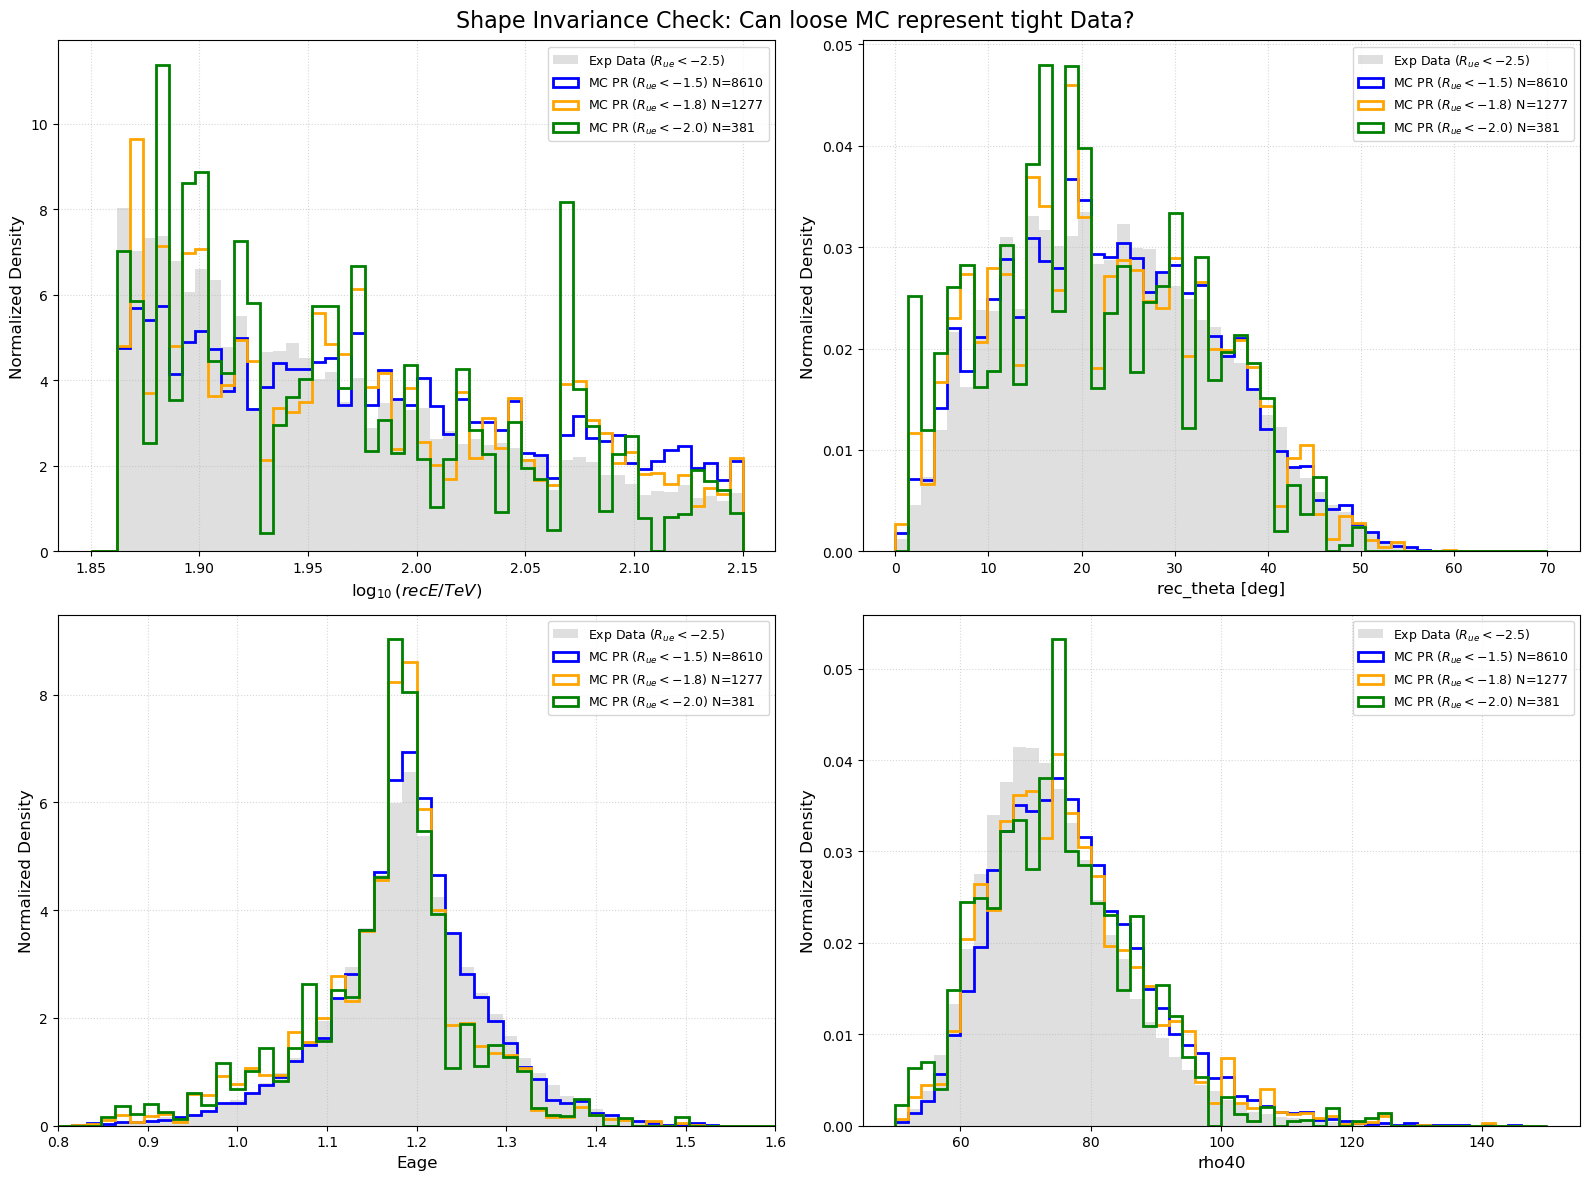

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def check_shape_invariance(df_mc, df_exp, 
                           cuts=[-1.5, -1.8, -2.0], 
                           target_exp_cut=-2.5):
    """
    验证 MC 在不同 R_ue 阈值下的形状稳定性，并与最终的实验数据对比
    """
    
    # --- 1. 参数配置 ---
    param_configs = {
        'recE':      {'range': (1.85, 2.15), 'label': r'$\log_{10}(recE/TeV)$', 'bins': 50},
        'rec_theta': {'range': (0, 70),      'label': r'rec_theta [deg]', 'bins': 50},
        'Eage':      {'range': (0.8, 1.6),   'label': 'Eage', 'bins': 50},
        'rho40':     {'range':(50,150),       'label': 'rho40', 'bins': 50}
        # 'R_mean':    {'range': (0, 90),      'label': 'R_mean [m]', 'bins': 50},
        
    }
    
    # 颜色循环，用于不同的 MC Cut
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    # --- 2. 绘图初始化 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    print(f">>> 开始验证形状不变性...")
    print(f"    MC Cuts: {cuts}")
    print(f"    Exp Target: R_ue < {target_exp_cut}")

    # --- 3. 循环绘制每个参数 ---
    for i, (p_name, cfg) in enumerate(param_configs.items()):
        ax = axes[i]
        
        # -------------------------------------------------
        # A. 绘制 EXP Data (作为最终的目标参考 - Ground Truth)
        # -------------------------------------------------
        exp_mask = df_exp['R_ue'] < target_exp_cut
        exp_vals = df_exp[p_name].values[exp_mask]
        exp_weights = df_exp['weight'].values[exp_mask]
        
        # 单位转换
        if p_name == 'rec_theta': exp_vals = exp_vals * 180 / np.pi
        
        ax.hist(exp_vals, bins=cfg['bins'], range=cfg['range'], weights=exp_weights,
                density=True, histtype='stepfilled', color='gray', alpha=0.25,
                label=f'Exp Data ($R_{{ue}} < {target_exp_cut}$)')
        
        # -------------------------------------------------
        # B. 循环绘制 MC Proton (不同宽松度的 Cut)
        # -------------------------------------------------
        for j, cut in enumerate(cuts):
            # 筛选
            mc_mask = df_mc['R_ue'] < cut
            mc_vals = df_mc[p_name].values[mc_mask]
            mc_weights = df_mc['gaisser_weight'].values[mc_mask]
            
            # 单位转换
            if p_name == 'rec_theta': mc_vals = mc_vals * 180 / np.pi
            
            # 统计量检查
            n_events = len(mc_vals)
            label = f'MC PR ($R_{{ue}} < {cut}$) N={n_events}'
            
            # 绘图
            ax.hist(mc_vals, bins=cfg['bins'], range=cfg['range'], weights=mc_weights,
                    density=True, histtype='step', linewidth=2, 
                    color=colors[j % len(colors)], label=label)

        # -------------------------------------------------
        # C. 美化
        # -------------------------------------------------
        ax.set_xlabel(cfg['label'], fontsize=12)
        ax.set_ylabel("Normalized Density", fontsize=12)
        # ax.set_title(f"Shape Stability: {cfg['label']}", fontweight='bold')
        ax.legend(fontsize=9, loc='upper right')
        ax.grid(True, linestyle=':', alpha=0.5)
        
        # Eage 稍微放大一点看细节
        if p_name == 'Eage':
            ax.set_xlim(0.8, 1.6)

    plt.suptitle(f"Shape Invariance Check: Can loose MC represent tight Data?", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# ==========================================
# 执行验证
# ==========================================
# 确保 df 中包含 gaisser_weight 和 weight 列
# 如果 recE 已经是 log 值了，上面代码会直接用；如果不是，请在传入前处理好
check_shape_invariance(pr_df_large, exp_muon_Rue_df_large, 
                       cuts=[-1.5, -1.8, -2.0,], 
                       target_exp_cut=-2.5)



>>> Loading Loose Data (Rue < -1.9)...
Sideband Events: MC=659, EXP=1662013

>>> Step 1: Sideband Calibration (Fixing Model Bias)...
[Eage] Calibration SHIFT: +0.0259
[R_mean] Calibration SCALE: 0.9422
[rec_theta] Calibration SHIFT: +0.0385

>>> Step 2: Profile Correction (Extrapolating to Signal Region)...
[Eage] Rue Trend Slope: 0.0232 / unit Rue
[R_mean] Rue Trend Slope: 3.9338 / unit Rue
[rec_theta] Rue Trend Slope: 0.0126 / unit Rue
Target Rue Mean estimated from Data: -2.843
>>> Profile Extrapolation: Moving from Rue=-1.068 to -2.843 (Delta=-1.775)
   -> Eage shifted by -0.0411
   -> R_mean shifted by -6.9809
   -> rec_theta shifted by -0.0224

>>> Final Validation...


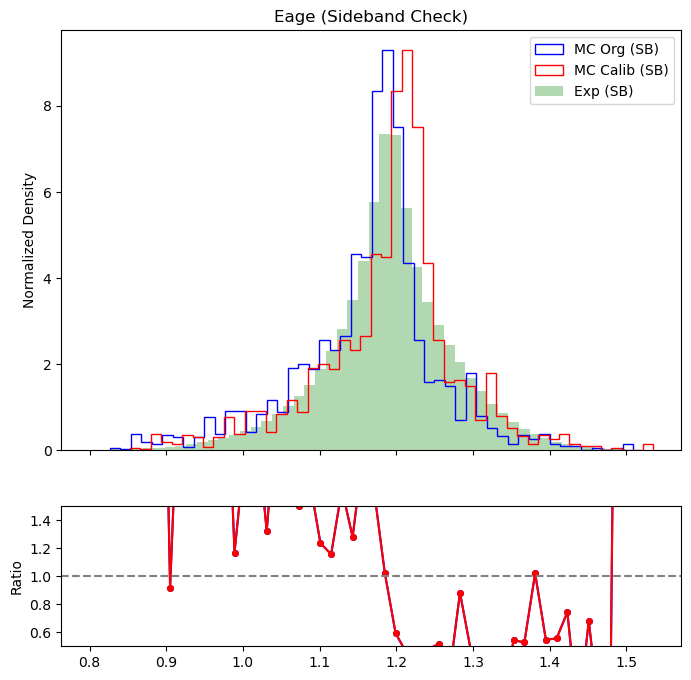

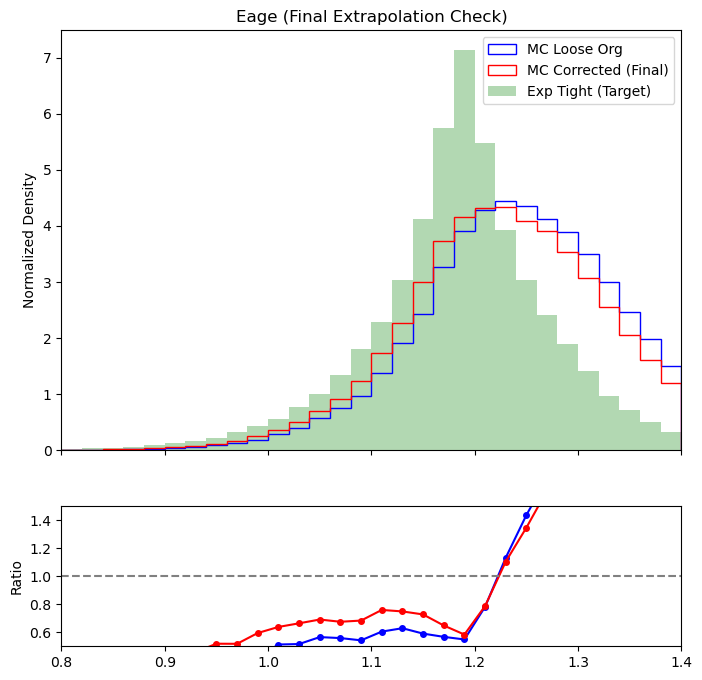

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from scipy.optimize import curve_fit

# ==========================================
# 0. 全局配置
# ==========================================
# 定义宽松的 Cut 用于加载数据 (保证统计量)
R_UE_LOOSE = -1.9 
# 定义最终分析的目标 Cut (信号区)
R_UE_TIGHT = -2.3 

# ==========================================
# 1. 核心工具类 (复用之前的逻辑并增强)
# ==========================================

class Plotter:
    COLORS = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    @staticmethod
    def plot_comparison(dfs, labels, var, weight_col, bins=50, range_val=None, title_suffix=""):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        hists = []
        for i, (df, label) in enumerate(zip(dfs, labels)):
            w = df[weight_col] if weight_col in df.columns else np.ones(len(df))
            is_ref = (i == len(dfs) - 1)
            h_type = 'stepfilled' if is_ref else 'step'
            alpha = 0.3 if is_ref else 1.0
            h, edges, _ = ax1.hist(df[var], bins=bins, range=range_val, weights=w,
                                   histtype=h_type, lw=2, alpha=alpha, density=True,
                                   label=label, color=Plotter.COLORS[i % len(Plotter.COLORS)])
            hists.append(h)
        ax1.set_ylabel('Normalized Density')
        ax1.legend()
        ax1.set_title(f'{var} {title_suffix}')
        
        centers = 0.5 * (edges[:-1] + edges[1:])
        ref_h = hists[-1] # 以最后一个(通常是Data)为基准
        for i in range(len(hists)-1):
            ratio = np.divide(hists[i], ref_h, out=np.zeros_like(hists[i]), where=ref_h!=0)
            ax2.plot(centers, ratio, 'o-', markersize=4, color=Plotter.COLORS[i], label=f'{labels[i]}/Data')
        ax2.axhline(1, color='gray', ls='--')
        ax2.set_ylabel('Ratio')
        if range_val: ax2.set_xlim(range_val)
        ax2.set_ylim(0.5, 1.5)
        plt.show()

class PhysicsMorpher:
    def __init__(self, baseline_df, target_df, weight_col='gaisser_weight'):
        self.base = baseline_df
        self.target = target_df
        self.w_col = weight_col
        self.strategies = {}

    def learn_diff(self, var, mode='shift'):
        b_vals = self.base[var]
        t_vals = self.target[var]
        w_b = self.base[self.w_col]
        w_t = self.target.get('weight', np.ones(len(t_vals))) # EXP通常用'weight'或1

        mean_base = np.average(b_vals, weights=w_b)
        mean_target = np.average(t_vals, weights=w_t)
        
        if mode == 'shift':
            val = mean_target - mean_base
            print(f"[{var}] Calibration SHIFT: {val:+.4f}")
        elif mode == 'scale':
            val = mean_target / mean_base
            print(f"[{var}] Calibration SCALE: {val:.4f}")
        self.strategies[var] = (mode, val)

    def apply(self, df):
        df_new = df.copy()
        for var, (mode, val) in self.strategies.items():
            if mode == 'shift': df_new[var] += val
            elif mode == 'scale': df_new[var] *= val
        return df_new

# ==========================================
# 2. 新增：Profile 修正器 (处理 R_ue 相关性)
# ==========================================

class ProfileCorrector:
    """
    负责修正由于 R_ue 切选不同导致的分布偏差。
    利用 Data 在 Sideband 的趋势 (Slope) 进行外推。
    """
    def __init__(self, data_df, rue_col='R_ue'):
        # 1. 拷贝数据以避免修改原始 DataFrame
        self.data = data_df.copy()
        self.rue_col = rue_col
        self.slopes = {}
        
        # 2. [关键修复] 初始化时强制清洗 R_ue 列
        # 将无法转为数字的变成 NaN，然后丢弃
        self.data[self.rue_col] = pd.to_numeric(self.data[self.rue_col], errors='coerce')
        
        # 检查并丢弃 R_ue 为 NaN 的行
        before_len = len(self.data)
        self.data = self.data.dropna(subset=[self.rue_col])
        if len(self.data) < before_len:
            print(f"ProfileCorrector 警告: 丢弃了 {before_len - len(self.data)} 个 R_ue 无效的事件")

    def learn_trend(self, target_vars, rue_range=(-3.0, -1.9)):
        """
        在指定 R_ue 范围内拟合变量随 R_ue 的线性变化率 (Slope)
        """
        # 1. 筛选范围内的 Data
        mask = (self.data[self.rue_col] > rue_range[0]) & (self.data[self.rue_col] < rue_range[1])
        df_fit = self.data[mask]
        
        if len(df_fit) < 10:
            print("错误: 拟合区间内数据太少，无法计算趋势！")
            for var in target_vars: self.slopes[var] = 0.0
            return

        # 获取 x 并确保是 float64
        x = df_fit[self.rue_col].values.astype(float)
        
        for var in target_vars:
            # 2. [关键修复] 强制清洗目标变量 (Y轴)
            # 处理可能存在的 object 类型
            y_series = pd.to_numeric(df_fit[var], errors='coerce')
            
            # 找出 x 和 y 都有效的索引
            valid_mask = ~np.isnan(y_series) & ~np.isnan(x)
            
            x_clean = x[valid_mask]
            y_clean = y_series.values[valid_mask]
            
            if len(x_clean) < 10:
                print(f"警告: 变量 {var} 有效数据不足，跳过拟合 (Slope=0)")
                self.slopes[var] = 0.0
                continue

            # 3. 线性拟合: y = kx + b
            try:
                p = np.polyfit(x_clean, y_clean, 1) # p[0] is slope
                self.slopes[var] = p[0]
                print(f"[{var}] Rue Trend Slope: {self.slopes[var]:.4f} / unit Rue")
            except Exception as e:
                print(f"[{var}] 拟合失败: {e}, 设置 Slope=0")
                self.slopes[var] = 0.0

    def apply_correction(self, df_mc, target_rue_mean):
        """
        将 MC 样本"推"到目标 R_ue 均值处
        Correction = Slope * (Target_Rue - Current_Rue_Mean)
        """
        df_new = df_mc.copy()
        
        # 同样需要确保 MC 的 R_ue 是数值型
        mc_rue = pd.to_numeric(df_new[self.rue_col], errors='coerce')
        current_rue_mean = mc_rue.mean()
        
        # 如果 MC 里全是 NaN，给一个默认值防止报错
        if np.isnan(current_rue_mean):
            print("警告: MC R_ue 全是 NaN，无法计算均值。跳过修正。")
            return df_new

        delta_rue = target_rue_mean - current_rue_mean
        
        print(f">>> Profile Extrapolation: Moving from Rue={current_rue_mean:.3f} to {target_rue_mean:.3f} (Delta={delta_rue:.3f})")
        
        for var, slope in self.slopes.items():
            # 确保目标列也是数值型，否则加法会报错
            df_new[var] = pd.to_numeric(df_new[var], errors='coerce')
            
            # 线性修正：假设分布整体随 Rue 平移
            shift_val = slope * delta_rue
            df_new[var] = df_new[var] + shift_val
            # 填充因类型转换可能产生的 NaN (可选)
            # df_new[var] = df_new[var].fillna(0) 
            
            print(f"   -> {var} shifted by {shift_val:.4f}")
            
        return df_new
# ==========================================
# 3. 执行流程
# ==========================================

# --- 3.1 加载宽松数据 (Rue < -1.9) ---
# 请确保 filter_dataset 中 R_ue_high 设置为 -1.9 或在外部重置
# R_ue_high = -1.9 (在调用 filter_dataset 前设置)
print("\n>>> Loading Loose Data (Rue < -1.9)...")

# 假设已经加载到 pr_df_loose (MC) 和 exp_df_loose (Data)
# 这里为了演示，直接使用你已有的变量名逻辑，假设它们包含 R_ue < -1.9 的数据
# pr_df_large -> MC Loose
# exp_muon_Rue_df_large -> EXP Loose

# --- 3.2 定义区域 ---
# Sideband (用于校准 Data/MC 差异): -2.3 < Rue < -1.9
# 我们认为在这个区域，物理规律和 Signal Region 是一致的
SB_MASK_MC = (pr_df_large['R_ue'] > -2.3) & (pr_df_large['R_ue'] < -1.9)
SB_MASK_EXP = (exp_muon_Rue_df_large['R_ue'] > -2.3) & (exp_muon_Rue_df_large['R_ue'] < -1.9)

pr_sb = pr_df_large[SB_MASK_MC].copy()
exp_sb = exp_muon_Rue_df_large[SB_MASK_EXP].copy()

print(f"Sideband Events: MC={len(pr_sb)}, EXP={len(exp_sb)}")

# --- 3.3 第一步：Sideband Calibration (Fix Simulation) ---
print("\n>>> Step 1: Sideband Calibration (Fixing Model Bias)...")
# 学习 MC 和 Data 在 Sideband 的差异
calib = PhysicsMorpher(pr_sb, exp_sb, weight_col='gaisser_weight')
calib.learn_diff('Eage', mode='shift')
calib.learn_diff('R_mean', mode='scale')
calib.learn_diff('rec_theta', mode='shift') # Theta 也可以 shift 或 reweight

# 应用校准到整个宽松 MC 样本
# 现在的 pr_df_calib 是一个"物理模型修正过"的 Loose MC
pr_df_calib = calib.apply(pr_df_large)

# --- 3.4 第二步：Profile Extrapolation (Fix Rue Cut Bias) ---
print("\n>>> Step 2: Profile Correction (Extrapolating to Signal Region)...")

# 1. 学习趋势: 使用 Data (Loose) 学习参数随 Rue 的变化
# 我们信任 Data 的趋势 (Slope)，因为 Data 包含了真实的关联性
corrector = ProfileCorrector(exp_muon_Rue_df_large)
corrector.learn_trend(['Eage', 'R_mean', 'rec_theta'], rue_range=(-2.3, -1.9))

# 2. 确定目标中心:
# 我们想要模拟的是 R_ue < -2.3 的背景
# 从 Data 中估算目标区域的 R_ue 均值 (假设 Data 在那里是背景)
# 或者如果 Data 在那里也没多少，可以取 -2.3 到 -3.0 的中心，比如 -2.5
target_rue_mean = exp_muon_Rue_df_large[exp_muon_Rue_df_large['R_ue'] < -2.3]['R_ue'].mean()
if np.isnan(target_rue_mean): target_rue_mean = -2.5 # Fallback
print(f"Target Rue Mean estimated from Data: {target_rue_mean:.3f}")

# 3. 应用修正:
# 把 "Loose MC" (均值约 -2.1) 推到 "Signal Region" (均值约 -2.5)
pr_df_final = corrector.apply_correction(pr_df_calib, target_rue_mean)

# --- 3.5 验证与结果 ---
print("\n>>> Final Validation...")

# 验证1: 在 Sideband 看校准效果 (应该完美重合)
Plotter.plot_comparison(
    [pr_sb, calib.apply(pr_sb), exp_sb], 
    ['MC Org (SB)', 'MC Calib (SB)', 'Exp (SB)'], 
    'Eage', 'gaisser_weight', 
    title_suffix="(Sideband Check)"
)

# 验证2: 最终结果 (Loose MC Corrected vs Tight Data)
# 这一步对比的是：
# 1. MC Loose -> Calib -> Profile Extrapolated
# 2. Data Tight (R_ue < -2.3) -- 这是真值！
exp_tight = exp_muon_Rue_df_large[exp_muon_Rue_df_large['R_ue'] < -2.3]

Plotter.plot_comparison(
    [pr_df_large, pr_df_final, exp_tight],
    ['MC Loose Org', 'MC Corrected (Final)', 'Exp Tight (Target)'],
    'Eage', 'gaisser_weight',
    bins=30, range_val=(0.8, 1.4),
    title_suffix="(Final Extrapolation Check)"
)

# 最终 pr_df_final 就是你可以用来作为 "背景" 送入 XGB 的 DataFrame
# 它拥有足够的统计量（来自 Loose Cut），且经过了物理和运动学修正。
